### Data reading and cleaning functions

#### Initial exploration of data present in files

In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from collections import Counter

In [2]:
data_dir = 'Training_WFDB/'
test_mat_file = data_dir + 'A0001.mat'
test_hea_file = data_dir + 'A0001.hea'

test_data = loadmat(test_mat_file)

print(test_data.keys())

# mat files only have a 'val' field in them. Checking what is in this field

test_data = test_data['val']
print(test_data.shape)
print(test_data.dtype)
print(test_data[0,:10])

# mat files seem to have the 12 channel EEG data in them.
# Reading header file

with open(test_hea_file, 'r') as f:
    test_header_data = f.readlines()

print(test_header_data)

# Header file seems to have a mix of file information, date and time of the recording, patient data, eeg recording information
# and labels. Extracting relevant data to further identify

for i in range(len(test_header_data)):
    print(test_header_data[i])

# Based on this, the first element has the recording name, number of leads, sampling rate, number of samples, and date and time
# when the recording was made.
# The next few lines have a description of which lead were connected and some information including the ADC resolution,
# bit width, some other undiscernable information, and finally the name of the lead.
# The next lines are the patient data which includes age, sex, and diagnosis
# Features relevant to us include the age, sex, and diagnosis code which will be our target classes
# Looking at some other fields, it seems none of the other parameters, i.e. order of leads or ADC resolutions etc ever change

dict_keys(['val'])
(12, 7500)
int16
[28 39 45 49 54 56 58 60 60 61]
['A0001 12 500 7500 12-May-2020 12:33:59\n', 'A0001.mat 16+24 1000/mV 16 0 28 -1716 0 I\n', 'A0001.mat 16+24 1000/mV 16 0 7 2029 0 II\n', 'A0001.mat 16+24 1000/mV 16 0 -21 3745 0 III\n', 'A0001.mat 16+24 1000/mV 16 0 -17 3680 0 aVR\n', 'A0001.mat 16+24 1000/mV 16 0 24 -2664 0 aVL\n', 'A0001.mat 16+24 1000/mV 16 0 -7 -1499 0 aVF\n', 'A0001.mat 16+24 1000/mV 16 0 -290 390 0 V1\n', 'A0001.mat 16+24 1000/mV 16 0 -204 157 0 V2\n', 'A0001.mat 16+24 1000/mV 16 0 -96 -2555 0 V3\n', 'A0001.mat 16+24 1000/mV 16 0 -112 49 0 V4\n', 'A0001.mat 16+24 1000/mV 16 0 -596 -321 0 V5\n', 'A0001.mat 16+24 1000/mV 16 0 -16 -3112 0 V6\n', '#Age: 74\n', '#Sex: Male\n', '#Dx: 59118001\n', '#Rx: Unknown\n', '#Hx: Unknown\n', '#Sx: Unknown\n']
A0001 12 500 7500 12-May-2020 12:33:59

A0001.mat 16+24 1000/mV 16 0 28 -1716 0 I

A0001.mat 16+24 1000/mV 16 0 7 2029 0 II

A0001.mat 16+24 1000/mV 16 0 -21 3745 0 III

A0001.mat 16+24 1000/mV 16 0 -17 36

(12, 7500)
74 Male 59118001


100%|█████████████████████████████████████████████████████████| 13754/13754 [00:01<00:00, 7424.39it/s]


['-1' '1' '10' '104' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20'
 '21' '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34'
 '35' '36' '37' '38' '39' '4' '40' '41' '42' '43' '44' '45' '46' '47' '48'
 '49' '5' '50' '51' '52' '53' '54' '55' '56' '57' '58' '59' '6' '60' '61'
 '62' '63' '64' '65' '66' '67' '68' '69' '7' '70' '71' '72' '73' '74' '75'
 '76' '77' '78' '79' '8' '80' '81' '82' '83' '84' '85' '86' '87' '88' '89'
 '9' '90' '91' '92' '93' '94' '95' '96' '97' '98' 'NaN']
['Female' 'Male']
['164884008' '164884008,164931005' '164884008,429622005' '164889003'
 '164889003,164884008' '164889003,164909002'
 '164889003,164909002,429622005' '164889003,164931005'
 '164889003,284470004' '164889003,429622005' '164889003,59118001'
 '164909002' '164909002,164884008' '164909002,164931005'
 '164909002,284470004' '164931005' '270492004' '270492004,164884008'
 '270492004,164909002' '270492004,164931005' '270492004,284470004'
 '270492004,429622005' '270492004,59118001' '284

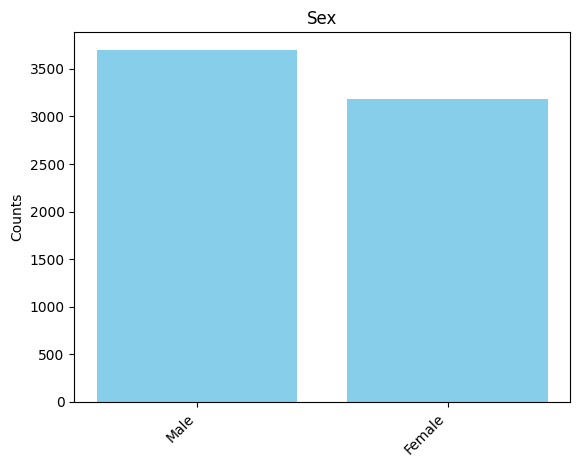

Occurances of age -1:  4
Occurances of age NaN:  5
['164884008' '164889003' '164909002' '164931005' '270492004' '284470004'
 '426783006' '429622005' '59118001']
Total number of labels:  9


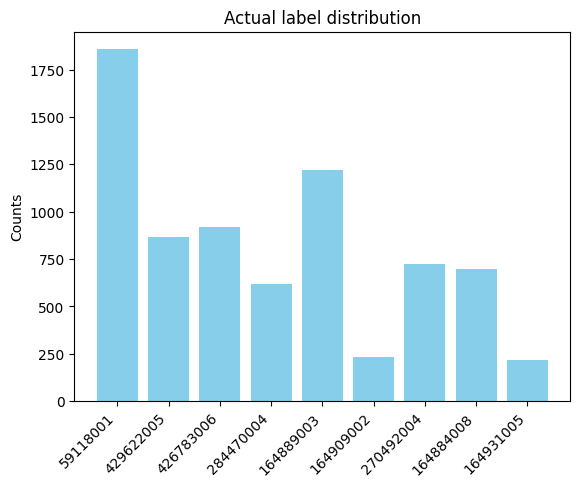

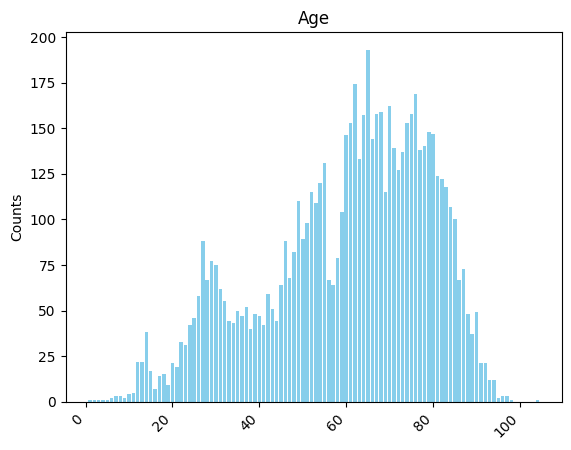

In [3]:
# Writing some data loading functions based on this information

def load_file(filename):
    dat = loadmat(filename)
    data = np.array(dat['val']).astype(np.float32)
    return data

def extract_features_from_header(filename):
    with open(filename, 'r') as f:
        header_data = f.readlines()

    age_field = 13
    sex_field = 14
    diagnosis_field = 15

    age = header_data[age_field][6:-1]
    sex = header_data[sex_field][6:-1]
    label = header_data[diagnosis_field][5:-1]

    return age, sex, label

def load_all_from_file(filename):
    data = load_file(filename)
    age, sex, label = extract_features_from_header(filename[:-4]+'.hea')
    return data, age, sex, label

# Ensuring the functions work correctly

data, age, sex, label = load_all_from_file(test_mat_file)
print(data.shape)
print(age, sex, label)

# We will have to transform categorical data fields into usable data formats.
# Particularly, the sex and class labels must be integer encoded.
# We can loop over all files and extract all unique values used in these fields to form the encoding maps

all_age, all_sex, all_labels = [], [], []
for file in tqdm(os.listdir(data_dir)):
    if '.hea' in file:
        age, sex, label = extract_features_from_header(data_dir + file)
        all_age.append(age)
        all_sex.append(sex)
        all_labels.append(label)

print(np.unique(all_age))
print(np.unique(all_sex))
print(np.unique(all_labels))

# We can see age has some odd values, particularly -1, and NaN
# Gender is always encoded as either Female or Male
# There are several label classes and sometimes we have more than a single label per file

# Plotting counts of variables to visualize distribution
# Helper function to plot counts
def plot_distribution(string_list, title):
    string_counts = Counter(string_list)
    labels = list(string_counts.keys())
    counts = list(string_counts.values())
    plt.title(title)
    plt.bar(labels, counts, color='skyblue')
    plt.ylabel('Counts')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# plot_distribution(all_age, 'Age') # Not displaying this as this is very messy
plot_distribution(all_sex, 'Sex')
# plot_distribution(all_labels, 'Labels') # Uncommented due to further processing under

# Checking individual counts of missing values. If they are very few, we can drop and preserve good quality data
# Otherwise, we can impute or fill in the missing values to ensure we have sufficient data

age_counts = Counter(all_age)
print("Occurances of age -1: ", age_counts['-1']) # Only 4
print("Occurances of age NaN: ", age_counts['NaN']) # Only 5

# Given we have almost 7000 recordings, we can drop the 9 that have missing age information
# Processing unique labels and determining the number

split_labels = []
for label in all_labels:
    if ',' in label:
        new_labels = label.split(',')
        for j in range(len(new_labels)):
            split_labels.append(new_labels[j])
    else:
        split_labels.append(label)

print(np.unique(split_labels))
print("Total number of labels: ", len(np.unique(split_labels)))
plot_distribution(split_labels, 'Actual label distribution')

# We only have 9 output classes however data is fairly imbalanced
# The age distrubition is messy at the moment but we can see that it is fairly widespread
# We can plot a better distribution after processing the age data

while ('-1' in all_age):
    all_age.remove('-1')

while ('NaN' in all_age):
    all_age.remove('NaN')

all_age = np.array(all_age).astype(int)
plot_distribution(all_age, 'Age')

# We can define maps to encode the data values as integers now

gender_map = {'Female': 0, 'Male': 1}
label_map = {'164884008': 0, '164889003': 1, '164909002': 2, 
             '164931005': 3, '270492004': 4, '284470004': 5,
             '426783006': 6, '429622005': 7, '59118001': 8}

### Data pre-processing

In [4]:
# Windowing data to pass it to a neural network. Will transform data of varying length to windows of the same size
def create_windows(signal, window_size):
    num_samples = signal.shape[1]
    windows = []
    for start in range(0, num_samples, window_size):
        end = start + window_size
        if end > num_samples:
            start = num_samples - window_size
            end = num_samples
        windows.append(signal[:, start:end])
        if end == num_samples:
            break
    return np.array(windows)

In [5]:
from sklearn.preprocessing import StandardScaler

age_scaler = StandardScaler().fit(all_age.reshape(-1, 1))
max_signal_abs_val = 40000  # ADC resolution normalization

# Initialize lists to store the data
X_list = []
ages_list = []
genders_list = []
y_list = []

window_size = 256

for file in tqdm(os.listdir(data_dir)):
    if file.endswith('.mat'):
        signals = load_file(data_dir + file) / max_signal_abs_val
        age, sex, raw_label = extract_features_from_header(data_dir + file[:-4] + '.hea')
        if age == '-1' or age =='NaN':
            continue
        sex = gender_map[sex]
        age = age_scaler.transform(np.array(age).reshape(-1, 1))[0, 0]
        label = np.zeros(9)
        if ',' in raw_label:
            for _label in raw_label.split(','):
                label[label_map[_label]] = 1
        else:
            label[label_map[raw_label]] = 1
        signal_windows = create_windows(signals, window_size)
        num_windows = signal_windows.shape[0]
        X_list.extend(signal_windows)
        genders_list.extend([sex] * num_windows)
        ages_list.extend([age] * num_windows)
        y_list.extend([label] * num_windows)

X = np.array(X_list)
ages = np.array(ages_list)
genders = np.array(genders_list)
y = np.array(y_list)
print(f"Final data shapes - X: {X.shape}, ages: {ages.shape}, genders: {genders.shape}, y: {y.shape}")

100%|██████████████████████████████████████████████████████████| 13754/13754 [00:22<00:00, 599.95it/s]


Final data shapes - X: (217496, 12, 256), ages: (217496,), genders: (217496,), y: (217496, 9)


In [6]:
class_counts = np.sum(y, axis=0)  # Sum along the samples axis to get counts for each class
class_weights = 1.0 / class_counts  # Inverse of class frequencies
sample_weights = np.zeros(y.shape[0])

for i in range(y.shape[0]):
    sample_weights[i] = np.sum(class_weights[y[i] == 1])
sample_weights *= len(sample_weights) / np.sum(sample_weights)

In [7]:
from sklearn.model_selection import train_test_split

def multilabel_stratify_labels(y):
    return ["_".join(str(int(i)) for i in label) for label in y]

stratify_labels = multilabel_stratify_labels(y)
indices = np.arange(len(y))
train_val_indices, test_indices = train_test_split(
    indices, test_size=0.15, stratify=stratify_labels, random_state=42
)
stratify_labels_train_val = np.array(stratify_labels)[train_val_indices]
train_indices, val_indices = train_test_split(
    train_val_indices, test_size=0.1765, stratify=stratify_labels_train_val, random_state=42
)

print(f"Training samples: {len(train_indices)}, Validation samples: {len(val_indices)}, Testing samples: {len(test_indices)}")

Training samples: 152241, Validation samples: 32630, Testing samples: 32625


In [8]:
import tensorflow as tf 
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam

def data_generator(X, y, genders, ages, sample_weights, indices):
    for idx in indices:
        yield (X[idx], genders[idx], ages[idx]), y[idx], sample_weights[idx]

def create_tf_dataset(X, y, genders, ages, sample_weights, indices, batch_size=32):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(X, y, genders, ages, sample_weights, indices),
        output_signature=(
            (tf.TensorSpec(shape=(12, 256), dtype=tf.float32),  # Shape of X[i]
             tf.TensorSpec(shape=(), dtype=tf.int32),            # Shape of genders[i]
             tf.TensorSpec(shape=(), dtype=tf.float32)),         # Shape of ages[i]
            tf.TensorSpec(shape=(9,), dtype=tf.float32),          # Shape of y[i]
            tf.TensorSpec(shape=(), dtype=tf.float32)            # Shape of sample_weights[i]
        )
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Create the tf.data.Dataset for each split
train_dataset = create_tf_dataset(X, y, genders, ages, sample_weights, train_indices, batch_size=32)
val_dataset = create_tf_dataset(X, y, genders, ages, sample_weights, val_indices, batch_size=32)
test_dataset = create_tf_dataset(X, y, genders, ages, sample_weights, test_indices, batch_size=32)

2024-08-19 22:28:52.849194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-19 22:28:52.903310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-19 22:28:52.903801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-19 22:28:52.905741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [15]:
# Inception Module Definition
def inception_module(input_tensor, filters):
    conv1 = layers.Conv1D(filters=filters, kernel_size=1, padding='same', activation='relu')(input_tensor)
    conv3 = layers.Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu')(input_tensor)
    conv5 = layers.Conv1D(filters=filters, kernel_size=5, padding='same', activation='relu')(input_tensor)
    pool_proj = layers.MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    pool_proj = layers.Conv1D(filters=filters, kernel_size=1, padding='same', activation='relu')(pool_proj)
    output = layers.concatenate([conv1, conv3, conv5, pool_proj], axis=-1)
    return output

# Build the model with possibly simplified architecture
def build_multi_input_model(signal_shape, num_classes):
    signal_input = Input(shape=signal_shape, name='signal_input')
    x = layers.Permute((2, 1))(signal_input)
    x = inception_module(x, 16)  # Use smaller number of filters
    x = inception_module(x, 16)
    x = inception_module(x, 16)
    x = layers.GlobalAveragePooling1D()(x)
    
    gender_input = Input(shape=(1,), name='gender_input', dtype=tf.float32)
    gender_dense = layers.Dense(8, activation='relu')(gender_input)
    
    age_input = Input(shape=(1,), name='age_input', dtype=tf.float32)
    age_dense = layers.Dense(8, activation='relu')(age_input)
    
    concatenated = layers.concatenate([x, gender_dense, age_dense])
    
    output = layers.Dense(64, activation='relu')(concatenated)
    output = layers.Dropout(0.5)(output)
    output = layers.Dense(num_classes, activation='sigmoid')(output)
    
    model = models.Model(inputs=[signal_input, gender_input, age_input], outputs=output)
    return model

# Model setup
signal_shape = (12, 256)
num_classes = 9
model = build_multi_input_model(signal_shape, num_classes)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], weighted_metrics=[])

In [16]:
# Training the Model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50)

# Evaluating the Model on the Test Set
model.evaluate(test_dataset)

Epoch 1/50


4758/4758 [==============================] - 48s 10ms/step - loss: 0.3386 - accuracy: 0.2963 - val_loss: 0.3050 - val_accuracy: 0.3427
Epoch 2/50
4758/4758 [==============================] - 48s 10ms/step - loss: 0.3082 - accuracy: 0.3613 - val_loss: 0.2895 - val_accuracy: 0.3872
Epoch 3/50
4758/4758 [==============================] - 49s 10ms/step - loss: 0.2963 - accuracy: 0.3919 - val_loss: 0.2800 - val_accuracy: 0.4238
Epoch 4/50
4758/4758 [==============================] - 48s 10ms/step - loss: 0.2879 - accuracy: 0.4133 - val_loss: 0.2722 - val_accuracy: 0.4388
Epoch 5/50
4758/4758 [==============================] - 49s 10ms/step - loss: 0.2826 - accuracy: 0.4249 - val_loss: 0.2686 - val_accuracy: 0.4518
Epoch 6/50
4758/4758 [==============================] - 52s 11ms/step - loss: 0.2784 - accuracy: 0.4352 - val_loss: 0.2635 - val_accuracy: 0.4640
Epoch 7/50
4758/4758 [==============================] - 54s 11ms/step - loss: 0.2747 - accuracy: 0.4426 - val_loss: 0.2604 - val_accura

[0.21080252528190613, 0.5492720603942871]

In [20]:
y_pred_prob = model.predict(test_dataset)

1020/1020 [==============================] - 6s 6ms/step


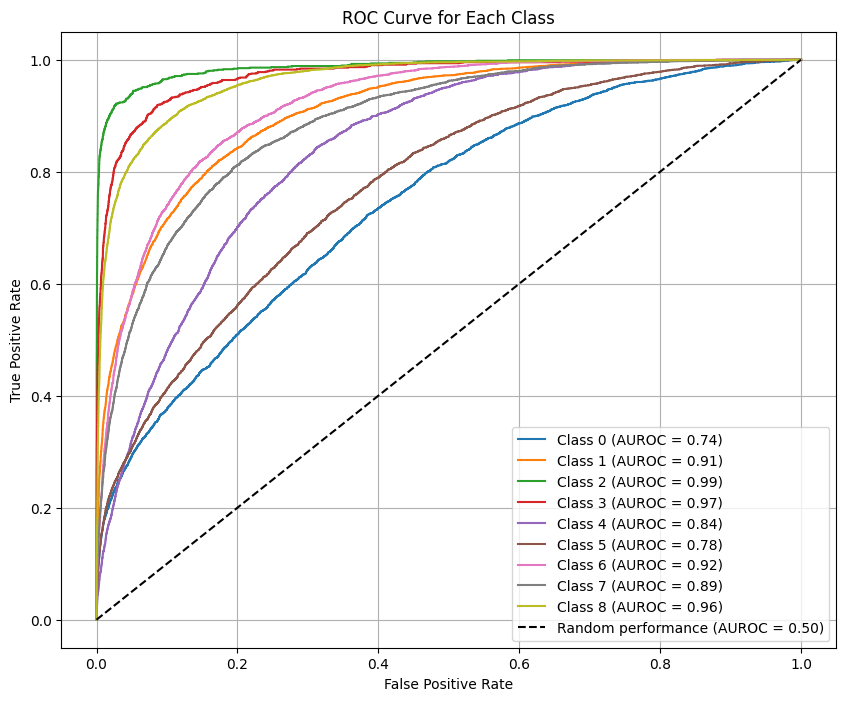

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test contains the true binary labels for each class
y_true = np.concatenate([y for x, y, sw in test_dataset], axis=0)

# Number of classes
n_classes = y_true.shape[1]

# Initialize variables to store ROC curve and AUROC metrics
fpr = {}
tpr = {}
roc_auc = {}

# Plotting the ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plotting the ROC curve for class i
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUROC = {roc_auc[i]:.2f})')

# Plot the diagonal line for random performance
plt.plot([0, 1], [0, 1], 'k--', label='Random performance (AUROC = 0.50)')

# Formatting the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
